# AFV code demonstration

##### Author: Jim Gatheral

We demonstrate the code used in the paper *Efficient simulation of affine forward variance models* available at  http://ssrn.com/abstract=3876680.

In [1]:
library(repr)

In [2]:
source("BlackFormula.R")
source("AFVsimulation.R")
source("GammaKernel.R")

In [3]:
bl <- "royalblue"
rd <- "red2"
pk <- "hotpink1"

### Parameters

We choose parameters similar to those found from a fit to SPX options as of May 19, 2017, the same data that was used in Roughening Heston.

In [4]:
params0 <- list(al=0.55,lam=0,eta=0.8,rho=-0.65, H=0.05,lam=0)
xi0 <- function(s){0.025+0*s} # The forward variance curve

### Simulation using the RSQE and HQE schemes

The option "all" returns a list with many variables of interest.

In [5]:
system.time(rsqe.sim <- RSQE.sim(params0, xi0)(paths=100000, steps=100, expiries=1,output="all"))

   user  system elapsed 
  6.633   2.338   8.988 

In [6]:
system.time(hqe.sim <- HQE.sim(params0, xi0)(paths=100000, steps=100, expiries=1,output="all"))

   user  system elapsed 
  9.106   3.143  12.260 

In [7]:
names(hqe.sim)

[1] "v" "x" "y" "w"

- v is terminal variance $v_T$
- x is terminal log-spot $X_T$
- y is terminal value of $Y_T = \int_0^T\,\sqrt{v_s}\,dW_s$.
- w is terminal value of quadratic variation $w_T = \int_0^T\,{v_s}\,ds$.

#### Parallelization

The code can be run in parallel with selected variables as output.

For example, here with $v_T$ as output.

In [8]:
library(foreach)
library(doParallel)

Loading required package: iterators

Loading required package: parallel



In [9]:
paths <- 1000000 # Note 1 million paths here!
steps <- 100

In [10]:
t0<-proc.time()

# Number of iterations
iters<- max(1,floor(paths/1000))

# Setup parallel backend to use all processors
(cl.num <- detectCores()) # Display number of processors on your machine
cl<-makeCluster(cl.num)
registerDoParallel(cl)

# Loop
ls <- foreach(icount(iters)) %dopar% {
        HQE.sim(params0, xi0)(paths=1000, steps=steps, expiries=1,output="v")
        }

stopCluster(cl)
    hqe.sim.v <- do.call(cbind, ls) #Bind all of the submatrices into one big matrix

print(proc.time()- t0)

[1] 16

   user  system elapsed 
  0.633   0.204  22.323 


### Figure 7.6: Histograms of $v_T$

In [11]:
options(repr.plot.width=14,repr.plot.height=7,repr.plot.res=150)

In [12]:
vv <- hqe.sim.v

In [13]:
vvg <- vv[vv > 1e-9] # Restrict sample to values greater than tiny

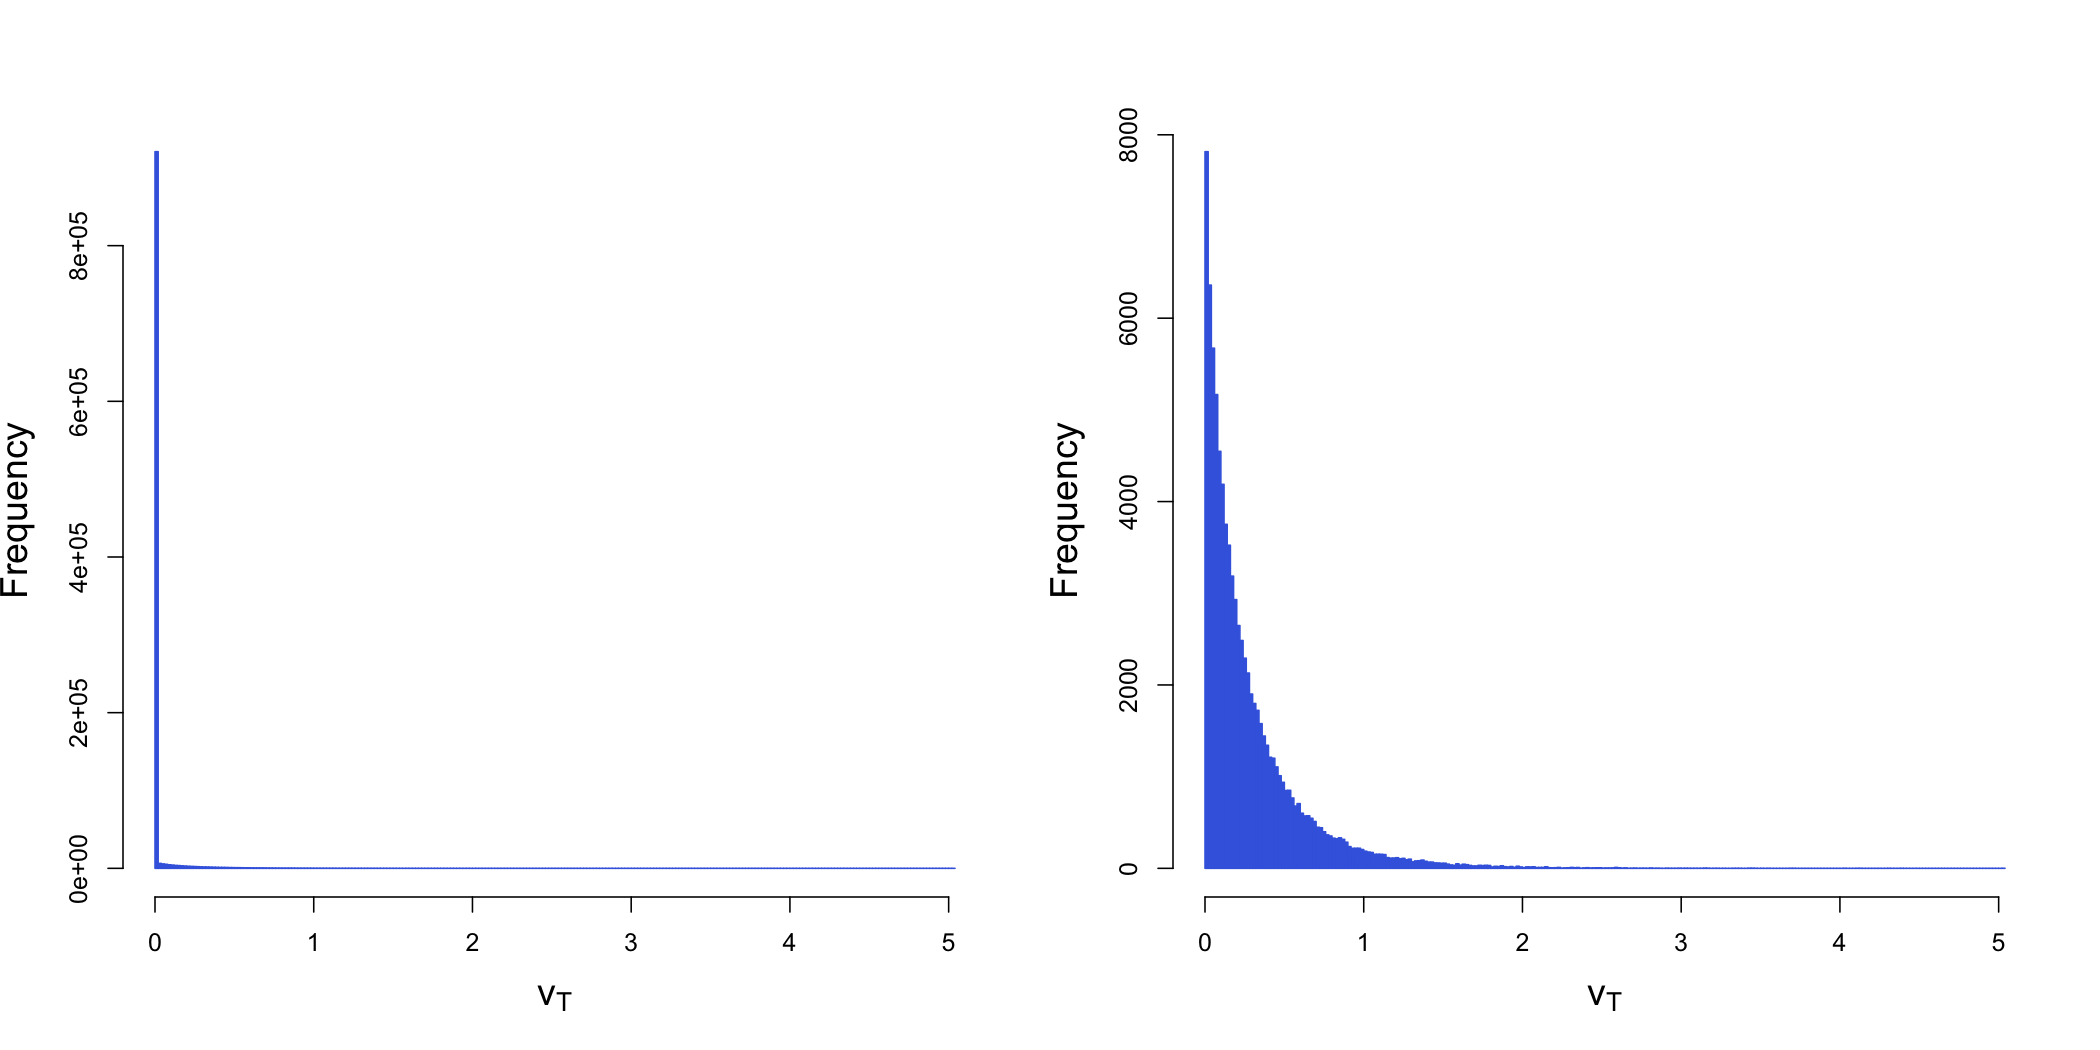

In [14]:
par(mfrow=c(1,2))
hist(vv,breaks=200,xlab=expression(v[T]),main="",col=bl, border=bl, cex.lab=1.5)
par(new=F)
hist(vvg,breaks=200,xlab=expression(v[T]),main="",col=bl,border=bl, cex.lab=1.5)
par(mfrow=c(1,1))

### Histograms of terminal stock prices

In [15]:
spots <- exp(hqe.sim$x)

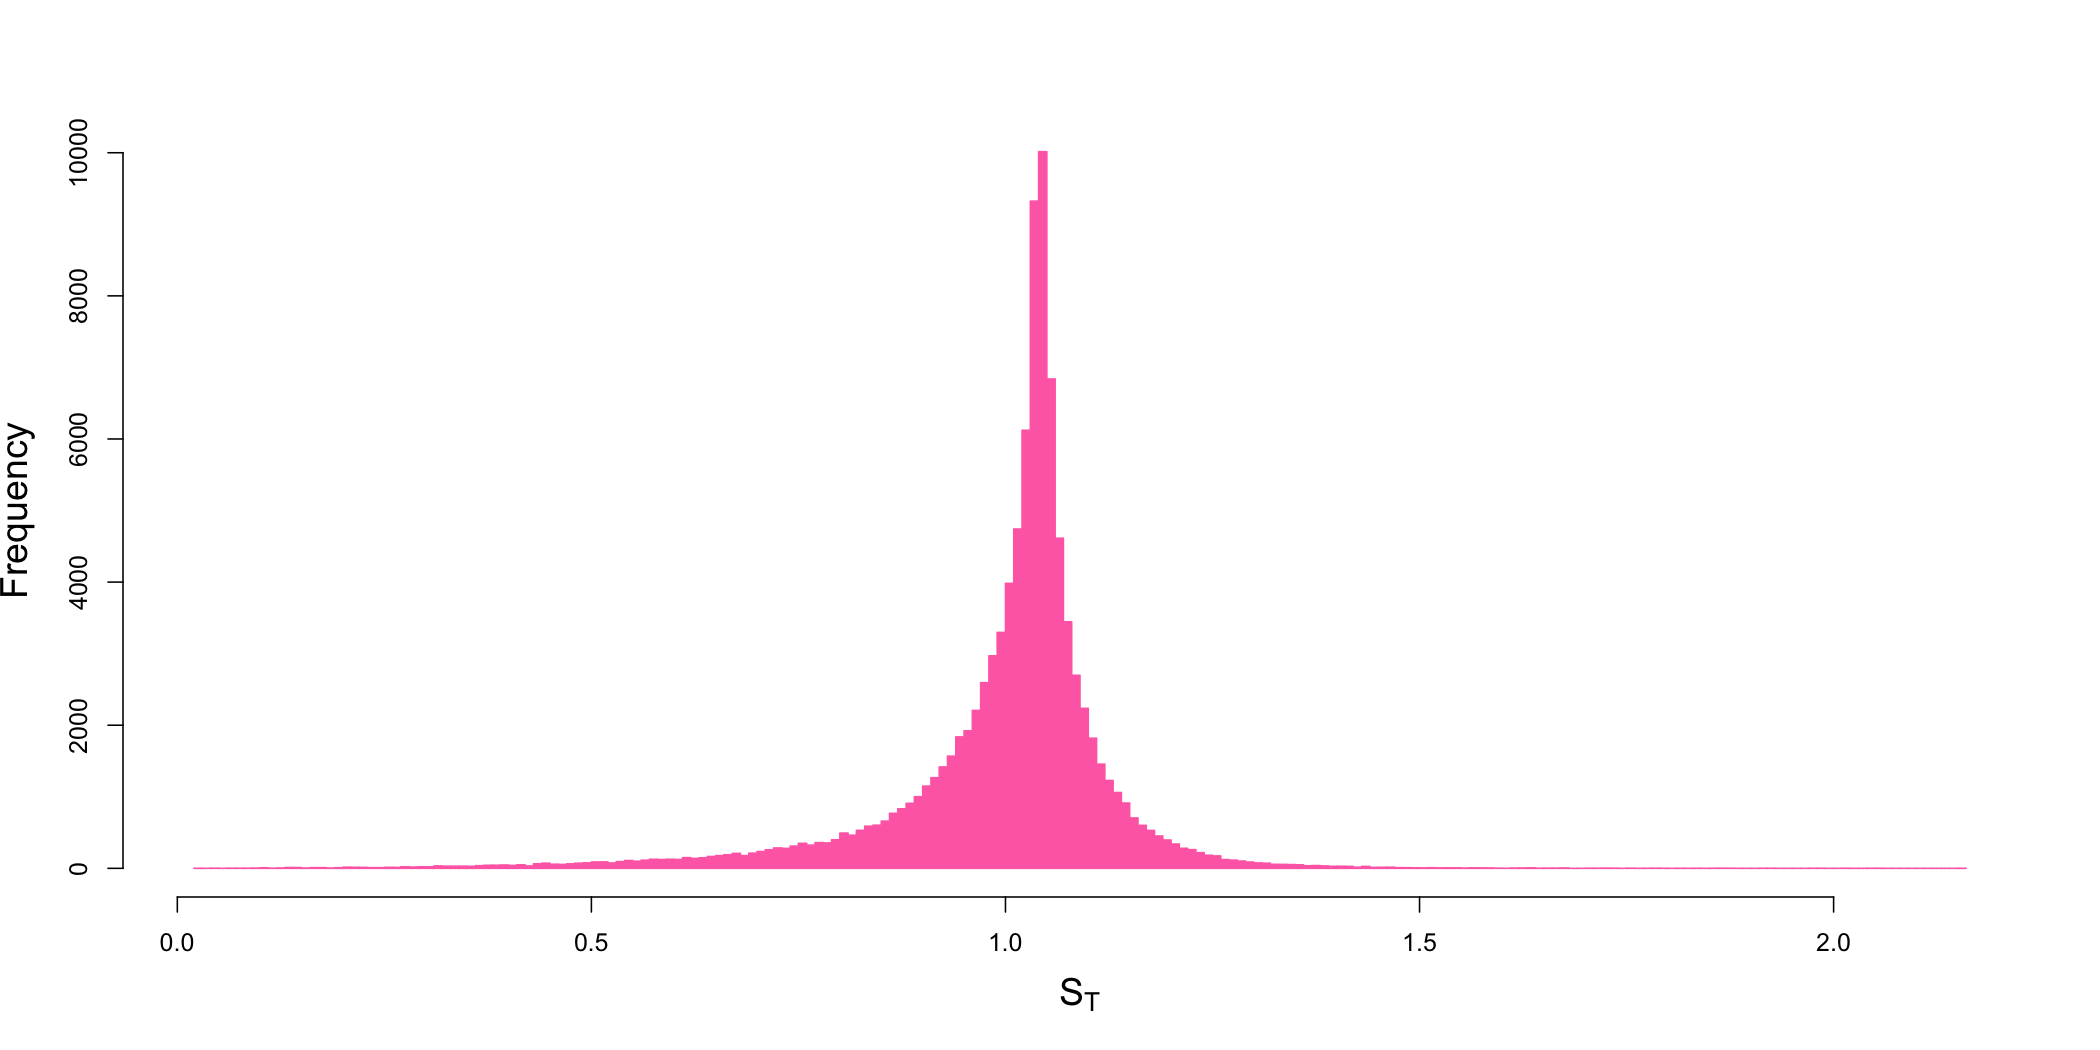

In [16]:
hist(spots,breaks=200,xlab=expression(S[T]),main="",col=pk, border=pk, cex.lab=1.5)

Note the fat negative tail in the return distribution.

### Draw the 1 year smile with the above parameters

In [17]:
s0 <- mean(spots)
smile <- function(k){ivS(spots, T=1, s0*exp(k))}

We select a vector of log-strikes.

In [18]:
kk <- seq(-.4,.4,.01)

In [19]:
smile.HQE <- smile(kk)

In [20]:
options(repr.plot.width=10,repr.plot.height=7,repr.plot.res=150)

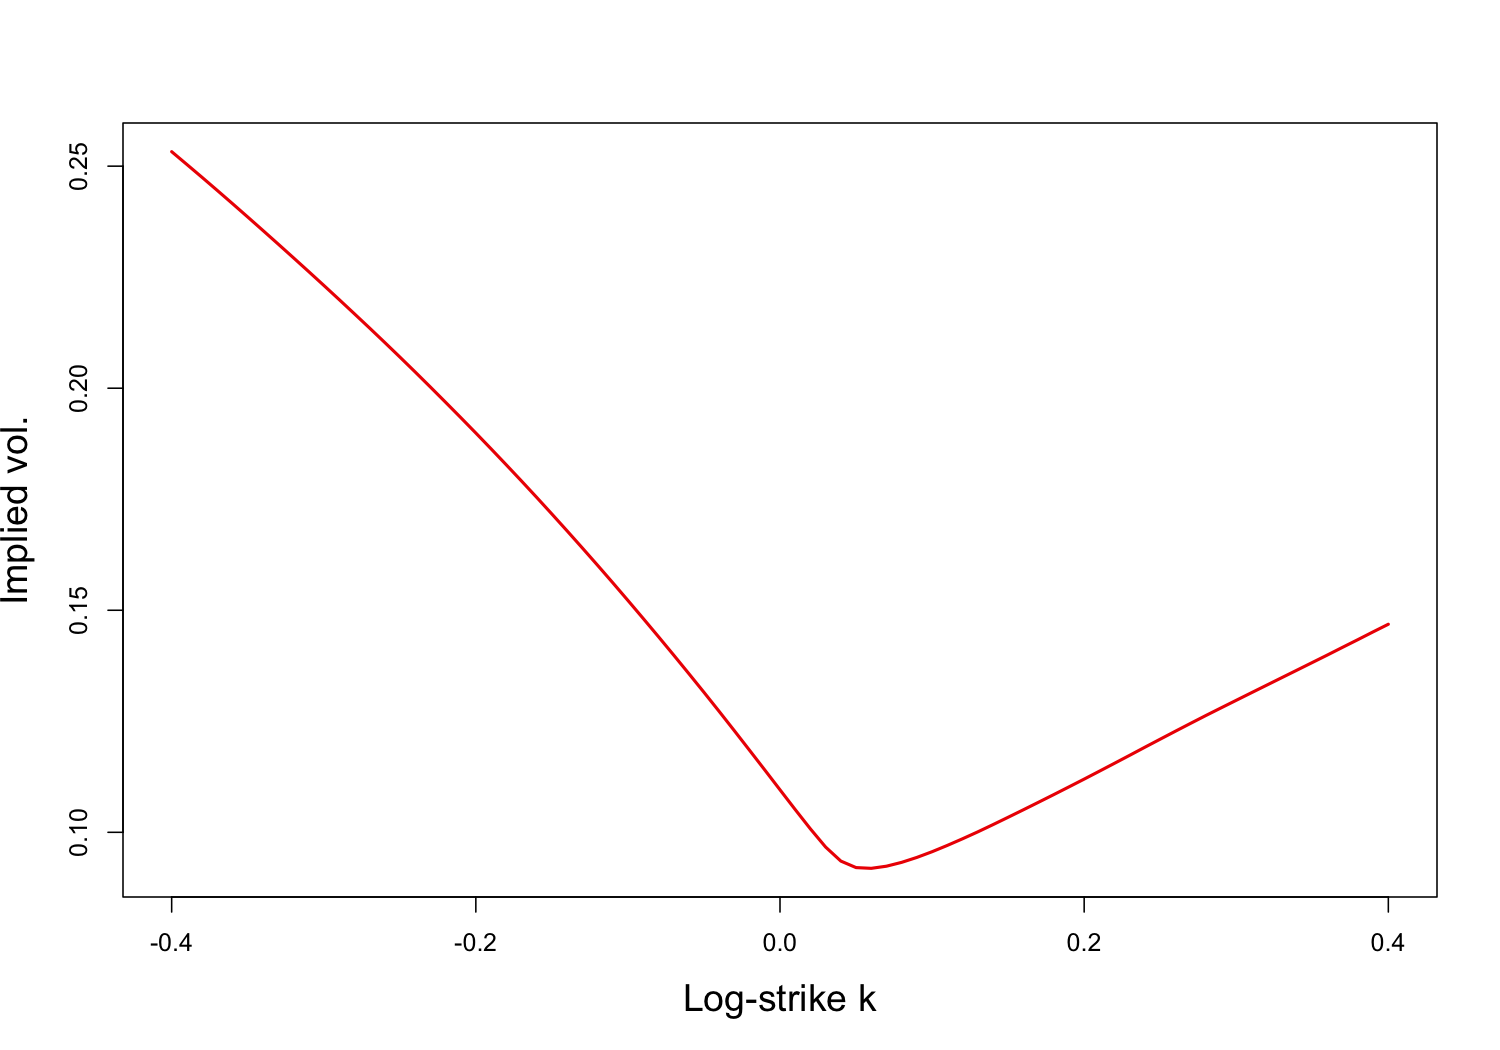

In [21]:
plot(kk,smile.HQE,col=rd,lwd=2,type="l",
     xlab="Log-strike k", ylab = "Implied vol.",cex.lab=1.5)